In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import datetime
import shutil

In [167]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample = pd.read_csv('./data/sample_submission.csv')

モデルの構築

In [168]:
X = train.drop(['ID','y'],axis=1)
y = train['y']
X_test = test.drop(['ID'],axis=1)

In [169]:
#オブジェクト型の列をワンホットエンコーディング
obj_idx = X.columns[X.dtypes == 'object']
encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
X_obj = X.loc[:,obj_idx]
X_test_obj = X_test.loc[:,obj_idx]
X_obj_encoded = encoder.fit(X_obj)
category_array = encoder.get_feature_names_out()

X_obj_encoded = encoder.transform(X_obj)
X_obj_encoded = pd.DataFrame(data=X_obj_encoded,columns=category_array,dtype='int64')
X_test_obj_encoded = encoder.transform(X_test_obj)
X_test_obj_encoded = pd.DataFrame(data=X_test_obj_encoded,columns=category_array,dtype='int64')

In [170]:
#エンコーディングした列を結合
all_idx = X.columns
other_idx = all_idx.difference(obj_idx)
X_other = X.loc[:,other_idx]
X_test_other = X_test.loc[:,other_idx]

X = pd.concat([X_obj_encoded,X_other],axis=1)
X_test = pd.concat([X_test_obj_encoded,X_test_other],axis=1)

テストデータの予測

In [171]:
seed=0
kf = KFold(n_splits=5,shuffle=True,random_state=seed)

model_list = []

for train_idx,valid_idx in kf.split(X,y):
    X_train,X_valid = X.iloc[train_idx,:],X.iloc[valid_idx,:]
    y_train,y_valid = y[train_idx],y[valid_idx]
    model = LGBMRegressor()
    model.fit(X_train,y_train)
    model_list.append(model)

In [172]:
model = LGBMRegressor()

In [173]:
train_sizes,train_scores,test_scores = learning_curve(
    estimator = model,
    X = X,
    y = y,
    cv = kf,
    scoring='neg_mean_squared_error'
)

In [174]:
train_scores = pd.DataFrame(train_scores)
train_scores['mean'] = train_scores.iloc[:,0:5].apply('mean',axis=1)
train_scores['std'] = train_scores.iloc[:,0:5].apply('std',axis=1)
train_scores['lower_bound'] = train_scores['mean'] - train_scores['std']
train_scores['upper_bound'] = train_scores['mean'] + train_scores['std']
test_scores = pd.DataFrame(test_scores)
test_scores['mean'] = test_scores.iloc[:,0:5].apply('mean',axis=1)
test_scores['std'] = test_scores.iloc[:,0:5].apply('std',axis=1)
test_scores['lower_bound'] = test_scores['mean'] - test_scores['std']
test_scores['upper_bound'] = test_scores['mean'] + test_scores['std']

In [175]:
train_scores

,0,1,2,3,4,mean,std,lower_bound,upper_bound
0,-23.943245,-27.766588,-19.849845,-27.129911,-25.768292,-24.891576,3.176589,-28.068165,-21.714988
1,-24.622041,-40.495703,-39.416215,-41.317518,-39.405262,-37.051348,6.994372,-44.045720,-30.056976
2,-27.217231,-38.141994,-37.245219,-36.508023,-37.621720,-35.346837,4.583413,-39.930250,-30.763425
3,-37.405771,-45.400762,-43.401882,-41.456833,-43.515880,-42.236226,3.039379,-45.275605,-39.196846
4,-38.581900,-44.338139,-41.634462,-40.335223,-42.731022,-41.524149,2.205540,-43.729689,-39.318609


In [176]:
train_scores['mean']

0   -24.891576
1   -37.051348
2   -35.346837
3   -42.236226
4   -41.524149
Name: mean, dtype: float64

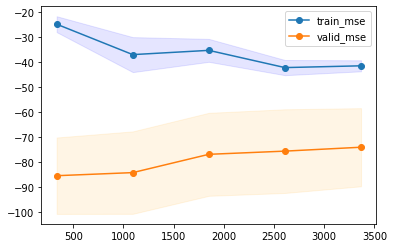

In [177]:
fig,ax = plt.subplots()
ax.plot(train_sizes,train_scores['mean'],marker='o',label='train_mse')
ax.fill_between(train_sizes,train_scores['lower_bound'],train_scores['upper_bound'],alpha=0.1, color='blue')
ax.plot(train_sizes,test_scores['mean'],marker='o',label='valid_mse')
ax.fill_between(train_sizes,test_scores['lower_bound'],test_scores['upper_bound'],alpha=0.1, color='orange')
ax.legend()
plt.show()

In [178]:
y_test_df = pd.DataFrame()

for i,model in enumerate(model_list):
    y_test = model.predict(X_test)
    y_test = pd.Series(y_test,name=f'model_{i}')
    y_test_df = pd.concat([y_test_df,y_test],axis=1)

y_test_df['mean'] = y_test_df.apply(np.mean,axis=1)
y_test_df

,model_0,model_1,model_2,model_3,model_4,mean
0,77.861477,78.986143,77.089067,78.326373,78.055206,78.063653
1,91.900752,92.200403,92.303366,94.444719,93.514640,92.872776
2,78.849386,78.486650,77.684314,76.959755,77.539814,77.903984
3,76.430056,74.662548,75.153708,76.278362,75.345961,75.574127
4,113.237159,113.168987,111.925914,115.154905,113.958187,113.489031
...,...,...,...,...,...,...
4204,106.695394,106.964232,106.842579,103.004145,103.444229,105.390116
4205,93.382693,94.151786,93.279256,94.760613,92.707041,93.656278
4206,91.319105,93.861480,92.630623,91.732304,92.018066,92.312316
4207,111.351424,111.261723,109.258027,108.068035,110.836774,110.155197


In [179]:
submit = pd.concat([test['ID'],y_test_df['mean']],axis=1)
submit.columns = ['ID','y']
now = datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')
submit_filename = f'submit_{now}' + '.csv'
submit.to_csv(submit_filename,index=None)
shutil.move(submit_filename,'./submit_files')

'./submit_files/submit_2022-07-14-13:41:04.csv'